# Proyek Klasifikasi Penyakit Jantung

**Author:** Putrawin Adha Muzakki  

## Dataset

Dataset yang digunakan adalah **UCI Heart Disease Dataset**, yang berisi 14 atribut klinis dari beberapa pusat medis.

- **Sumber:** https://www.kaggle.com/datasets/imnikhilanand/heart-attack-prediction
- **Format:** CSV (Comma-Separated Values).
- **Karakteristik Data:**
    - Terdiri dari fitur numerik dan kategorikal (yang sudah di-encode sebagai angka).
    - Terdapat banyak nilai yang hilang (*missing values*) yang ditandai dengan `?`.
    - Ditemukan adanya spasi ekstra pada nama kolom yang perlu dibersihkan.
---


1.  **Setup Lingkungan:**
    - Menghubungkan Google Colab dengan Google Drive untuk akses file.
    - Mengimpor semua library yang dibutuhkan, seperti `pandas`, `numpy`, dan `scikit-learn`.

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Import library fundamental untuk analisis data
import pandas as pd
import numpy as np

# Import library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Import library dari Scikit-Learn untuk machine learning
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler  # Kita akan tambahkan scaling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Mengatur tampilan output pandas agar semua kolom terlihat
pd.set_option('display.max_columns', None)

2.  **Pemuatan & Pembersihan Data Awal:**
    - Memuat dataset dari file CSV di Google Drive.
    - `na_values='?'` digunakan untuk secara otomatis mengonversi `?` menjadi `NaN`.
    - **Pembersihan Nama Kolom:** Semua nama kolom dibersihkan dari spasi ekstra di awal/akhir menggunakan `str.strip()` untuk menghindari `KeyError`.

In [19]:
# File path
file_path = '/content/drive/MyDrive/Studi_Independen/Tugas_1_Modul_4/data.csv'

# Membaca file CSV ke dalam pandas DataFrame
df = pd.read_csv(file_path, na_values='?')
print("File berhasil dimuat.")
print("Ukuran data:", df.shape)

# Membersihkan nama kolom dari spasi ekstra di awal atau akhir
df.columns = df.columns.str.strip()
print("\nNama kolom telah dibersihkan.")

# Tampilkan 5 baris pertama dan info dataframe
if 'df' in locals():
    print("\nData Awal (5 baris pertama):")
    display(df.head())
    print("\nInformasi DataFrame:")
    df.info()
    print("\nNama Kolom Setelah Dibersihkan:")
    print(df.columns.tolist()) # Menampilkan nama kolom dalam bentuk list

File berhasil dimuat.
Ukuran data: (294, 14)

Nama kolom telah dibersihkan.

Data Awal (5 baris pertama):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0



Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  num       294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB

Nama Kolom Setelah Dibersihkan:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


3.  **Preprocessing Data:**
    - **Penghapusan Kolom:** Kolom `slope`, `ca`, dan `thal` dihapus karena memiliki jumlah *missing values* yang sangat tinggi, sehingga tidak informatif.
    - **Pemisahan Data (Train-Test Split):** Data dipisahkan menjadi 80% data training dan 20% data testing **sebelum** proses imputasi dan scaling. Langkah ini krusial untuk mencegah *data leakage*.
    - **Imputasi Nilai Hilang:** `SimpleImputer` dengan strategi `median` digunakan untuk mengisi semua nilai `NaN` yang tersisa di seluruh fitur. Imputer di-*fit* hanya pada data training.
    - **Feature Scaling:** `StandardScaler` diterapkan untuk menormalkan skala semua fitur, yang penting untuk performa model linear seperti Logistic Regression. Scaler juga di-*fit* hanya pada data training.

In [20]:
# Cek jumlah data yang hilang (missing values) di setiap kolom
print("Jumlah Missing Values per Kolom (Awal):")
print(df.isnull().sum())
print("-" * 30)

# Hapus kolom yang terlalu banyak data hilang
df_processed = df.drop(columns=['slope', 'ca', 'thal'])

# Pisahkan fitur (X) dan target (y)
X = df_processed.drop('num', axis=1)
y = df_processed['num']

# Bagi data menjadi data training dan testingG
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")

Jumlah Missing Values per Kolom (Awal):
age           0
sex           0
cp            0
trestbps      1
chol         23
fbs           8
restecg       1
thalach       1
exang         1
oldpeak       0
slope       190
ca          291
thal        266
num           0
dtype: int64
------------------------------
Ukuran X_train: (235, 10)
Ukuran X_test: (59, 10)


In [21]:
# Buat instance Imputer dan Scaler
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Fit dan Transform pada Data Training
X_train_imputed = imputer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Transform pada Data Testing
# Menggunakan median dan standar deviasi yang sudah dipelajari dari data training
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

# Konfirmasi akhir bahwa tidak ada lagi NaN di data training
print("Jumlah NaN di X_train_scaled setelah preprocessing:", np.isnan(X_train_scaled).sum())
print("Jumlah NaN di X_test_scaled setelah preprocessing:", np.isnan(X_test_scaled).sum())

Jumlah NaN di X_train_scaled setelah preprocessing: 0
Jumlah NaN di X_test_scaled setelah preprocessing: 0


4.  **Pemodelan (Modeling):**
    - Dua model klasifikasi dievaluasi:
        1.  **Logistic Regression:** Sebagai model *baseline* yang sederhana dan mudah diinterpretasikan.
        2.  **Random Forest Classifier:** Sebagai model *ensemble* yang lebih kompleks untuk perbandingan.

--- Hasil Evaluasi: Logistic Regression ---
Accuracy: 0.8475

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88        38
           1       0.80      0.76      0.78        21

    accuracy                           0.85        59
   macro avg       0.84      0.83      0.83        59
weighted avg       0.85      0.85      0.85        59


Confusion Matrix:


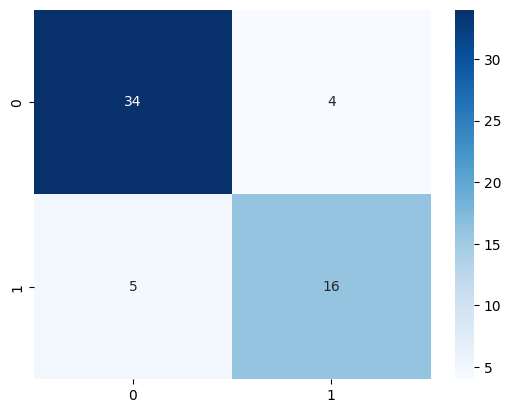

In [22]:
# Inisialisasi model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Latih model menggunakan data training yang sudah di-scaling
log_reg.fit(X_train_scaled, y_train)

# Buat prediksi pada data testing yang sudah di-scaling
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluasi performa model
print("--- Hasil Evaluasi: Logistic Regression ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', cmap='Blues')
plt.show()

--- Hasil Evaluasi: Random Forest Classifier ---
Accuracy: 0.7627

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.82        38
           1       0.71      0.57      0.63        21

    accuracy                           0.76        59
   macro avg       0.75      0.72      0.73        59
weighted avg       0.76      0.76      0.76        59


Confusion Matrix:


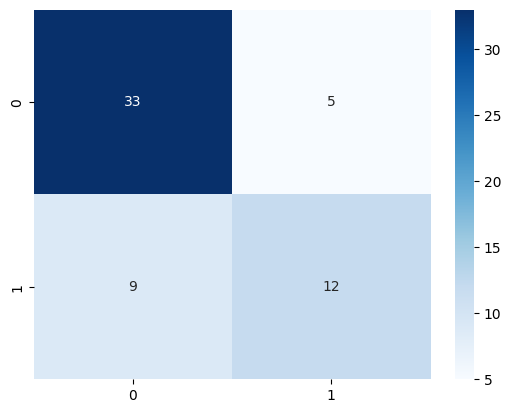

In [23]:
# Inisialisasi model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Latih model
rf_clf.fit(X_train_scaled, y_train)

# Buat prediksi
y_pred_rf = rf_clf.predict(X_test_scaled)

# Evaluasi performa model
print("--- Hasil Evaluasi: Random Forest Classifier ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.show()

## 4. Hasil & Pembahasan

| Model | Accuracy | Recall (Kelas 1) | Precision (Kelas 1) | False Negatives (FN) |
| :--- | :---: | :---: | :---: | :---: |
| **Logistic Regression** | **~85%** | **76%** | **80%** | **5** |
| Random Forest Classifier | ~76% | 57% | 71% | 9 |

- **Logistic Regression** menunjukkan performa yang **secara signifikan lebih baik** di semua metrik penting.
- **Random Forest Classifier** memiliki performa yang lebih buruk, kemungkinan besar karena **overfitting** pada dataset yang relatif kecil. Recall untuk kelas 1 sangat rendah (57%), yang berarti model ini melewatkan 43% pasien yang sakit, membuatnya tidak dapat diandalkan.
